# Pysumma functionality
This notebook gives a brief overview of pysumma functions. 

It was originally created by Bart Nijssen and Andrew Bennett (University of Washington) for the "CUAHSI Virtual University snow modeling course 2019". 
Modifications include a change of data and update of the naming scheme to comply with SUMMA v3.0.
Source: https://github.com/bartnijssen/cuahsi_vu_2019

## Loading the required modules

In [1]:
import pysumma as ps
import pysumma.plotting as psp
import matplotlib.pyplot as plt
!cd data/reynolds && ./install_local_setup.sh && cd -

/pool0/data/andrbenn/workspace/pysumma-tutorial


<br>

## Instantiating a simulation object

To set up a `Simulation` object you must supply 2 pieces of information. 

First, the SUMMA executable; this could be either the compiled executable on your local machine, or a docker image.  
The second piece of information is the path to the file manager, which contains all file paths and names needed for a SUMMA simulation run.
To create the `Simulation` object you can then just pass these to the constructor as shown below.

In [16]:
# Define location of .exe and file manager
executable = 'summa.exe'
file_manager = './data/reynolds/file_manager.txt'

In [17]:
# Create a model instance
s = ps.Simulation(executable, file_manager)

<br>

## Manipulating the configuration of the simulation object

Most of your interactions with pysumma will be facilitated through this `Simulation` object, so let's take some time to look through what is in it. 
What's contained in the `Simulation` object right after instantiation is generally just the input required for a SUMMA run.
For a more in depth discussion of what these are see the [SUMMA Input](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/) page of the documentation.
There are several attributes of interest that can be examined. 
To see each of them you can simply `print` them. 
Here's a very high level overview of what's available:

* `s.manager` - the file manager
* `s.decisions` - the decisions file
* `s.output_control` - defines what variables to write out
* `s.force_file_list` - a listing of all of the forcing files to use
* `s.local_attributes` - describes GRU/HRU attributes (lat, lon, elevation, etc)
* `s.global_hru_params` - listing of spatially constant local (HRU) parameter values
* `s.global_gru_params` - listing of spatially constant basin (GRU) parameter values
* `s.trial_params` - spatially distributed parameter values (will overwrite `local_param_info` values, can be either HRU or GRU)

Most of these objects have a similar interface defined, with exceptions being `local_attributes` and `parameter_trial`. Those two are standard `xarray` datasets. All others follow the simple API:

```
print(x)                   # Show the data as SUMMA reads it
x.get_option(NAME)         # Get an option
x.set_option(NAME, VALUE)  # Change an option
x.remove_option(NAME)      # Remove an option
```

More intuitively, you can use `key` - `value` type indexing like dictionaries, dataframes, and datasets:

```
print(x['key'])    # Get an option
x['key'] = value   # Change an option
```

### File manager
Let's take a look at what the file manager text file actually contains:

In [18]:
print(s.manager)

controlVersion                       'SUMMA_FILE_MANAGER_V3.0.0'
simStartTime                         '1999-10-01 01:00'
simEndTime                           '2002-09-30 23:00'
tmZoneInfo                           'localTime'
settingsPath                         '/pool0/data/andrbenn/workspace/pysumma-tutorial/data/reynolds/settings/'
forcingPath                          '/pool0/data/andrbenn/workspace/pysumma-tutorial/data/reynolds/forcing/'
outputPath                           '/pool0/data/andrbenn/workspace/pysumma-tutorial/data/reynolds/output/'
decisionsFile                        'snow_zDecisions.txt'
outputControlFile                    'snow_zOutputControl.txt'
globalHruParamFile                   'snow_zLocalParamInfo.txt'
globalGruParamFile                   'snow_zBasinParamInfo.txt'
attributeFile                        'snow_zLocalAttributes.nc'
trialParamFile                       'snow_zParamTrial.nc'
forcingListFile                      'forcing_file_list.txt'
initCondit

<br>

These are the file paths and names as the simulation object `s` knows them. You can compare this to the contents of the file  `./pbhm-exercise-2/settings/reynolds/summa_fileManager_reynoldsConstantDecayRate.txt` to see that they are identical. 
For this exercise, we'll focus on three items: the model decisions or parametrizations, parameter values and output control.

<br>

### Setting decisions

So, now that we've got a handle on what's available and what you can do with it, let's actually try some of this out. First let's just print out our decisions file so we can see what's in the defaults.
Note that this only prints the decisions specified in the decision file (`./pbhm-exercise-2/settings/reynolds/summa_zDecisions_reynoldsConstantDecayRate.txt`) and not all the model decisions that can be made in SUMMA. 
For a full overview of modelling decision, see the SUMMA documentation: https://summa.readthedocs.io/en/master/input_output/SUMMA_input/#infile_model_decisions


In [19]:
print(s.decisions)

soilCatTbl    ROSETTA              ! soil-category dataset
vegeParTbl    USGS                 ! vegetation-category dataset
soilStress    NoahType             ! choice of function for the soil moisture control on stomatal resistance
stomResist    BallBerry            ! choice of function for stomatal resistance
num_method    itertive             ! choice of numerical method
fDerivMeth    analytic             ! choice of method to calculate flux derivatives
LAI_method    monTable             ! choice of method to determine LAI and SAI
f_Richards    mixdform             ! form of Richards equation
groundwatr    qTopmodl             ! choice of groundwater parameterization
hc_profile    pow_prof             ! choice of hydraulic conductivity profile
bcUpprTdyn    nrg_flux             ! type of upper boundary condition for thermodynamics
bcLowrTdyn    zeroFlux             ! type of lower boundary condition for thermodynamics
bcUpprSoiH    liq_flux             ! type of upper boundary condi

<br> 

Great, we can see what's in there. But to be able to change anything we need to know the available options for each decision. Let's look at how to do that. For arbitrary reasons we will look at the `snowIncept` option, which describes the parameterization for snow interception in the canopy. First we will get it from the `decisions` object directly, and then query what it can be changed to, then finally change the value to something else.

<br>

In [20]:
# Get just the `snowIncept` option
print(s.decisions['snowIncept'])

# Look at what we can set it to
print(s.decisions['snowIncept'].available_options)

# Change the value 
s.decisions['snowIncept'] = 'stickySnow'
print(s.decisions['snowIncept'])

snowIncept    lightSnow            ! choice of parameterization for snow interception
['stickySnow', 'lightSnow']
snowIncept    stickySnow           ! choice of parameterization for snow interception


<br>

### Changing parameters

Much like the decisions we can manipulate the `gloabl_hru_param` file. First, let's look at what's contained in it:

In [21]:
print(s.global_hru_params)

upperBoundHead            |      -7.5d-1 |      -1.0d+2 |      -1.0d-2
lowerBoundHead            |       0.0000 |      -1.0d+2 |      -1.0d-2
upperBoundTheta           |       0.2004 |       0.1020 |       0.3680
lowerBoundTheta           |       0.1100 |       0.1020 |       0.3680
upperBoundTemp            |     272.1600 |     270.1600 |     280.1600
lowerBoundTemp            |     274.1600 |     270.1600 |     280.1600
tempCritRain              |     273.1600 |     272.1600 |     274.1600
tempRangeTimestep         |       2.0000 |       0.5000 |       5.0000
frozenPrecipMultip        |       1.0000 |       0.5000 |       1.5000
snowfrz_scale             |      50.0000 |      10.0000 |    1000.0000
fixedThermalCond_snow     |       0.3500 |       0.1000 |       1.0000
albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoMinWinter           |       0.5500 |       0.6000 |       1.0000
albedoMinSpring           |       0.5500 |       0.3000 |       1.0000
albedo

<br>

Yikes, that's pretty long. Let's change something for the sake of it:

In [22]:
# Print it
print('old: ' + str(s.global_hru_params['albedoMax']))

# Change the value
s.global_hru_params['albedoMax'] = 0.9
print('new: ' + str(s.global_hru_params['albedoMax']))

old: albedoMax                 |       0.8400 |       0.7000 |       0.9500
new: albedoMax                 |       0.9000 |       0.9000 |       0.9000


<br>

### Modifying output
And one more, we can also modify what get's written to output. 
The output control file represents the options available through columns of numeric values.
These numbers represent how to write the output. 
From the SUMMA documentation (https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/#output-control-file) they are arranged as:

```
! varName          | outFreq | inst | sum | mean | var | min | max | mode
```

As before, let's look at what's in the `output_control` by simply printing it out:


In [23]:
print(s.output_control)

nSnow                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSWE                            | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowDepth                      | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowfallTemp                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowAge                        | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarExfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarTotalSoilLiq                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarTotalSoilIce                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceRunoff                  | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceTemp                    | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowSublimation                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarLatHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSenHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowDrainage                

<br>

Note that SUMMA is pretty flexible in its output. What we see above is a pretty typical output file configuration that contains most of the major state variables and fluxes. For a more complete overview of what you can ask SUMMA to output, see: https://github.com/NCAR/summa/blob/master/build/source/dshare/var_lookup.f90

We can modify values in the existing `output_control` in a couple of ways:

In [24]:
# Check the settings for one of the output variables
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

# Change the output statistic from instantaneous to sum
s.output_control['scalarInfiltration'] = [1, 1, 0, 0, 0, 0, 0, 0]
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

# We could also be more verbose:
s.output_control['scalarInfiltration'] = {
    'period': 1, 'instant': 1, 'sum': 0, 
    'mean': 0, 'variance': 0, 'min': 0, 'max': 0
}
print(s.output_control['scalarInfiltration'])
print(s.output_control['scalarInfiltration'].statistic)

scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant
scalarInfiltration                   | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0
sum
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
instant


<br>

## Running pysumma and manipulating output

Now that you've had an overview of how you can interact with SUMMA configurations through pysumma let's run a simulation. 
Before doing so we will reset our `Simulation` object, which will discard all of the changes we've made and load in a clean setup. 
Alternatively you could simply instantiate a new `Simulation` object.
After running the simulation, we will make sure that it completed successfully by checking the status.
With a complete run, we can look at the output simply by using the simulation's `output` attribute.
It is simply an xarray dataset, which can be manipulated in all of the usual ways.

In [25]:
s.reset()
# Or you could just create a new simulation object like before:
#s = ps.Simulation(executable, file_manager)

<br>

Before we run the model, we need to ensure that the output directory specified in the fileManger actually exists. If it doesn't, SUMMA will notify you of this and abort the simulation.

In [26]:
# module to handle tasks related to files and folders
import os 

# Make the output directory if it doesn't exist
print('Current specified output directory: ' + s.manager['outputPath'].value) 
if not os.path.exists(s.manager['outputPath'].value):
    os.makedirs(s.manager['outputPath'].value)

Current specified output directory: /pool0/data/andrbenn/workspace/pysumma-tutorial/data/reynolds/output/


<br>

Now we can try a model run.

In [27]:
s.run('local', run_suffix='_default') # run_suffix allows you to specify a string that will be added to the output file name. This is very useful to keep track of different experiments
print(s.status)

Success


You should have gotten a `'Success'` printed out after running the simulation. For further details about the simulation you can look at the full output log that SUMMA produces by printing out `s.stdout`. In the event that `s.status` does not return `Success` you may wish to inspect this log to diagnose the problem further. `s.stderror` and `s.stdout` can provide details about the error.

<br>

## Plotting

Now that we've got some output we can plot some results. Because the output is an xarray `DataSet` we can use the convenient plotting capabilities provided by xarray.

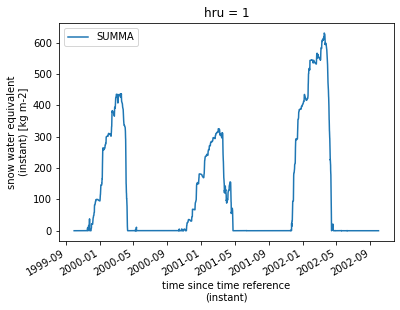

In [29]:
s.output['scalarSWE'].plot(label='SUMMA');
plt.legend(); # note that 'plt' relies on: 'import matplotlib.pyplot as plt' which is magically included in the line `%pylab inline` in the first code block

<br>

Additionally, pysumma provides some more specialized plotting capabilities. To access it we have the `ps.plotting` module. First, lets plot the vertical layers over time. For this we will use `ps.plotting.layers`, which requires two pieces of information. First, the variable that you want to plot. It should have both `time` and `midToto` dimensions. The first plot we will make will be the temperature, which uses the variable `mLayerTemp`, and the second will be the volumetric fraction of water content in each layer, which uses `mLayerVolFracWat`. To start out we will give these more convenient names.


In [30]:
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

Now we can plot this using our function. For the temperature plot we will set `plot_soil` to `False` so that we only plot the snowpack. We can see that the top layers of the snowpack respond more quickly to the changing air temperature, and that later in the season the warmer air causes temperature transmission to lower layers and ultimately melts out. 

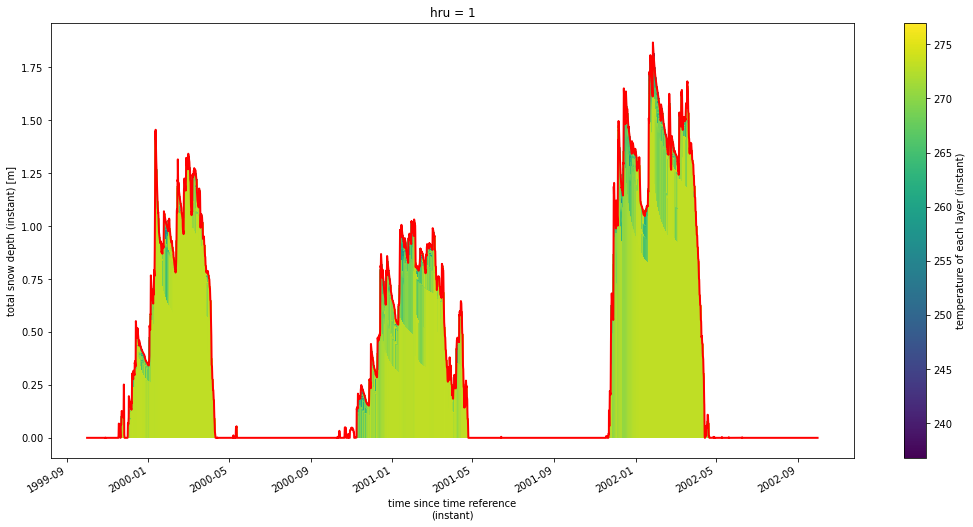

In [31]:
psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);

By looking at the volumetric water content we can see even more details. Now we will set `plot_soil` to `True` so that we can see how snowmelt can cause water infiltration into the soil. For example, during the melt season in 2012 we can easily see how the snowmelt infiltrates into the ground.

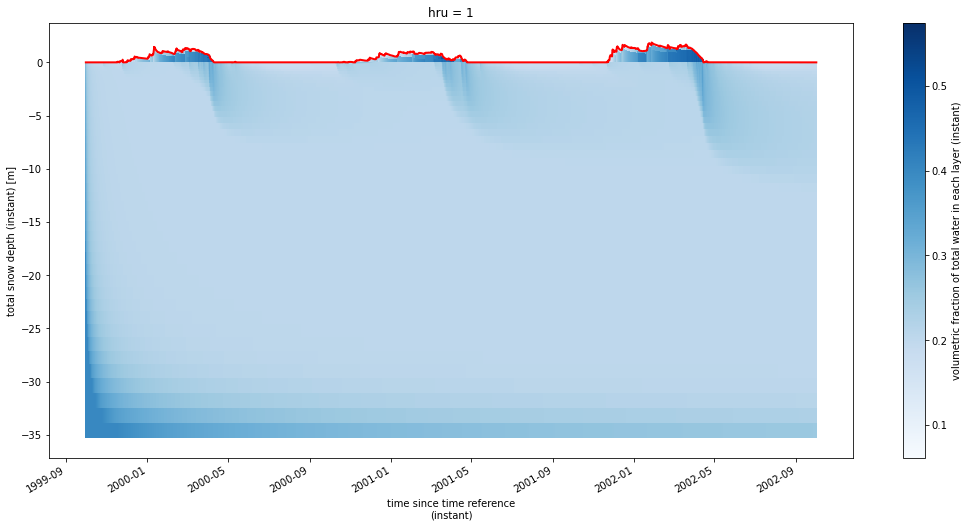

In [32]:
psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);